In [35]:
import seaborn as sb
import matplotlib.pyplot as pl
import pandas as pd
import pymc3 as pm
import numpy as np
from scipy import stats
% matplotlib inline
% precision 2

'%.2f'

In [5]:
tips = sb.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


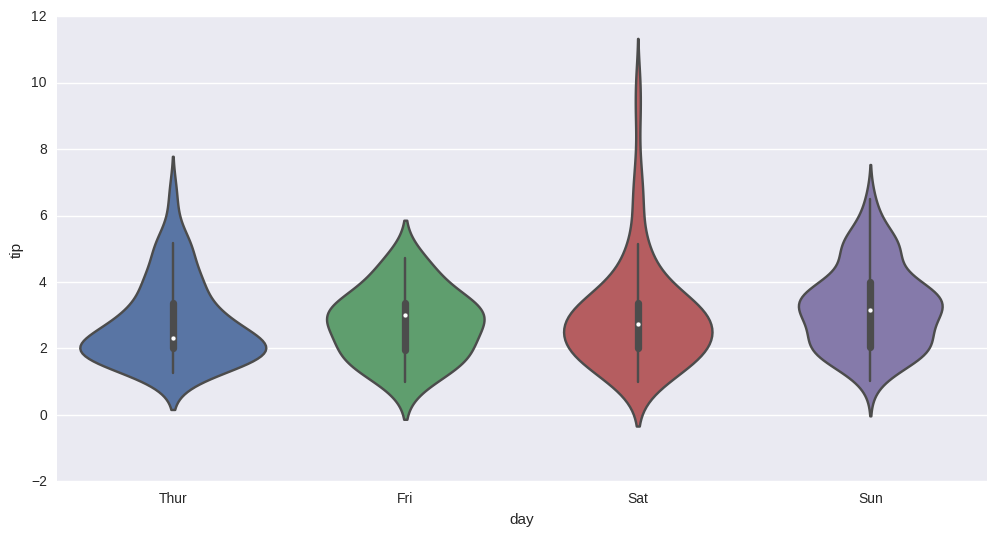

In [4]:
f, ax = pl.subplots(figsize=(12,6))
sb.violinplot(x='day', y='tip', data=tips, ax=ax);

In [114]:
yobs = tips['tip'].values
catsTransf= pd.Categorical(tips['day'])

In [115]:
idx=catsTransf.codes
cats = catsTransf.categories

In [127]:
catsTransf.categories

Index(['Thur', 'Fri', 'Sat', 'Sun'], dtype='object')

In [129]:
tips.day

0       Sun
1       Sun
2       Sun
3       Sun
4       Sun
5       Sun
6       Sun
7       Sun
8       Sun
9       Sun
10      Sun
11      Sun
12      Sun
13      Sun
14      Sun
15      Sun
16      Sun
17      Sun
18      Sun
19      Sat
20      Sat
21      Sat
22      Sat
23      Sat
24      Sat
25      Sat
26      Sat
27      Sat
28      Sat
29      Sat
       ... 
214     Sat
215     Sat
216     Sat
217     Sat
218     Sat
219     Sat
220     Fri
221     Fri
222     Fri
223     Fri
224     Fri
225     Fri
226     Fri
227     Sat
228     Sat
229     Sat
230     Sat
231     Sat
232     Sat
233     Sat
234     Sat
235     Sat
236     Sat
237     Sat
238     Sat
239     Sat
240     Sat
241     Sat
242     Sat
243    Thur
Name: day, dtype: category
Categories (4, object): [Thur, Fri, Sat, Sun]

In [109]:
pd.CategoricalIndex(tips['day']).codes

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0], dtype=int8)

In [28]:
with pm.Model() as comparing_groups:
    # priors
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd = 10, shape=len(set(idx)))
    
    # likelihood
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=yobs)
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -447.77: 100%|██████████| 200000/200000 [00:26<00:00, 7472.86it/s]
Finished [100%]: Average ELBO = -447.8
100%|██████████| 5000/5000 [00:08<00:00, 562.14it/s]


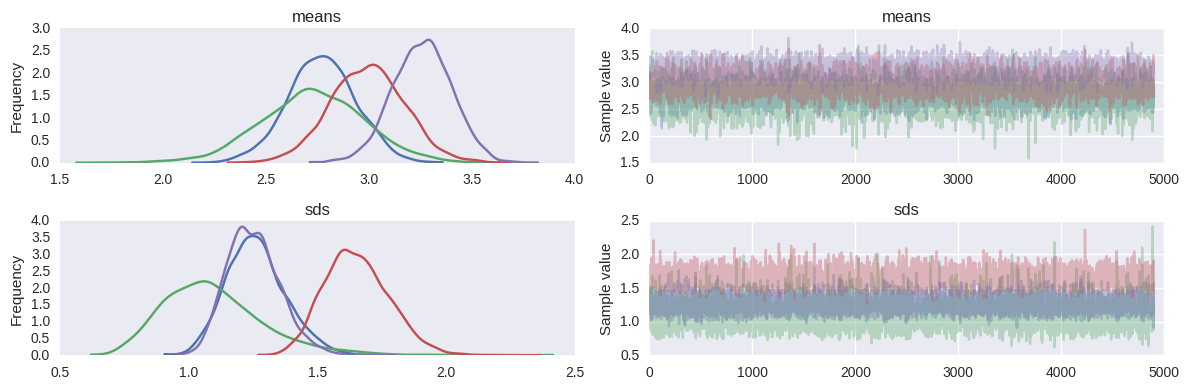

In [29]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg);

**Diagnostics**
***

In [30]:
pm.df_summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,2.769195,0.164612,0.002084,2.461726,3.110160
means__1,2.726907,0.252515,0.003990,2.243506,3.233563
means__2,2.991665,0.179998,0.002546,2.635796,3.339814
means__3,3.256969,0.142882,0.001706,2.978047,3.535531
sds__0,1.263125,0.115740,0.001433,1.047822,1.498854
sds__1,1.100527,0.199832,0.003061,0.741704,1.484134
sds__2,1.654210,0.125198,0.001698,1.410112,1.885504
sds__3,1.252130,0.101680,0.001262,1.057631,1.447514


In [50]:
def PlotComparisonStats(chain, d_cohen=False):
    # d_cohen and pro_sup a
    _, ax = pl.subplots(3,2, figsize=(16,12))
    comparisons = [(i,j) for i in range(4) for j in range(i+1,4)]
    pos=[(k,l) for k in range(3) for l in (0,1)]
    for (i, j), (k,l) in zip(comparisons, pos):
        means_diff = chain['means'][:,i] - chain['means'][:,j]
        pm.plot_posterior(means_diff, ref_val=0,
                          ax=ax[k,l], color='skyblue')
        ax[k,l].set_xlabel('$\mu_%d - \mu_%d$' % (i,j), fontsize=18)
        if d_cohen:
            d_cohen = (means_diff / np.sqrt((chain['sds'][:,i]**2 +
                                             chain['sds'][:,j]**2)
                                            /2)).mean()
            dist = stats.norm()
            ps = dist.cdf(d_cohen/(2**0.5))
            ax[k,l].plot(0, label="Cohen's d = %.2f\nProb sup= %.2f"
                     % (d_cohen, ps), alpha=0)
            ax[k,l].legend(loc=0, fontsize=14)

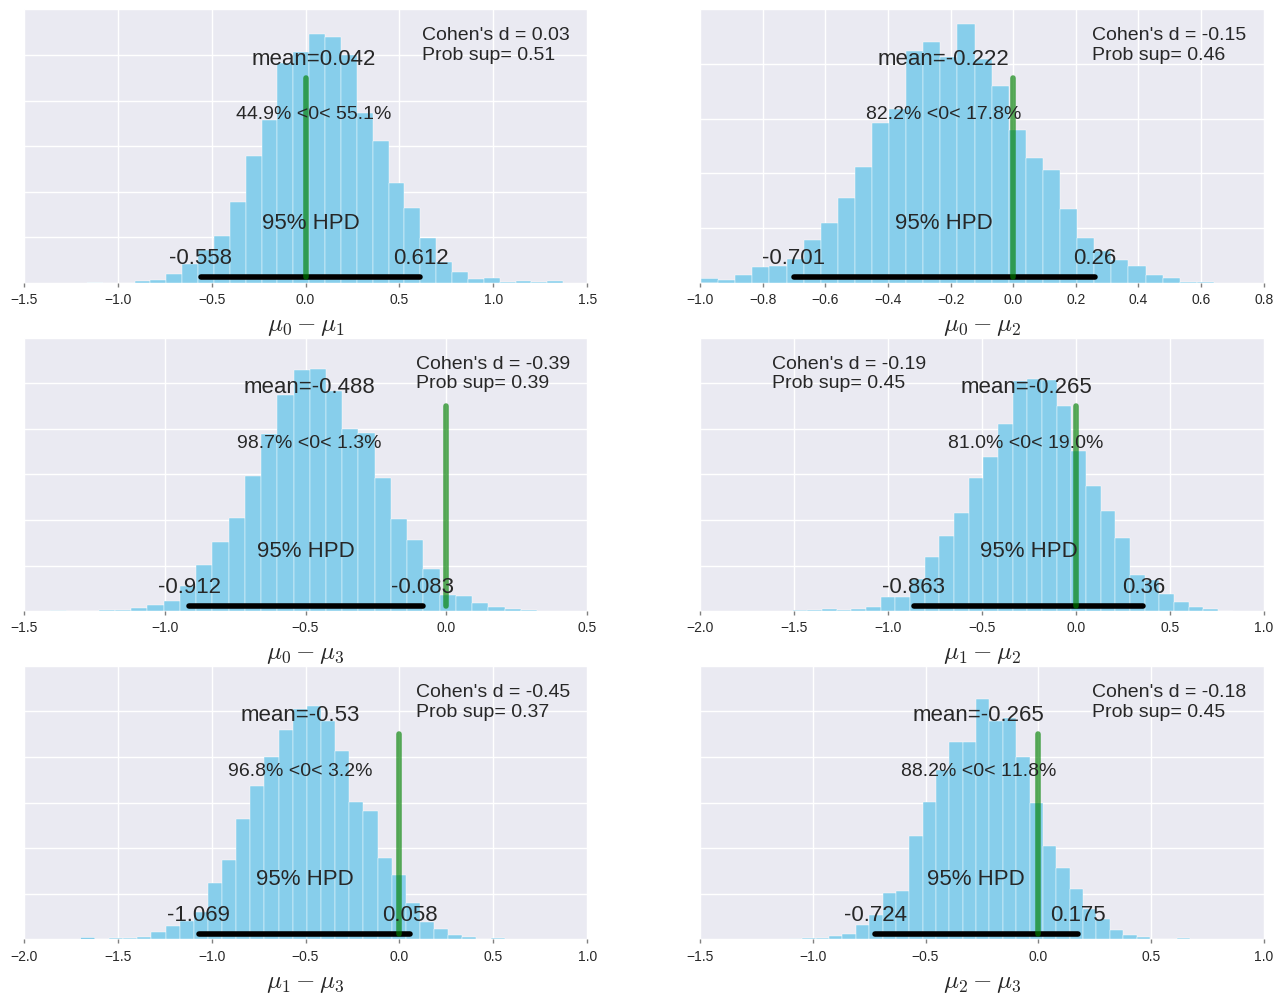

In [51]:
PlotComparisonStats(chain_cg, d_cohen=True)

---
***Exercise:***

1 - Modify the tips example to make it robust to outliers. Try: 

    a. with one $\nu$ shared for all groups 
    
    b. with one $\nu$ per group. 

2 - Run posterior predictive checks to assess these three models.

---

In [22]:
print(tips.tip.mean())
print(tips.tip.std())
print(tips.tip.min(), tips.tip.max())

2.9982786885245902
1.3836381890011826
1.0 10.0


In [19]:
yobs = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [58]:
# For 1 I'm going to replace the gaussian in the previous model with a t-distribution
with pm.Model() as robust_grp_cmp:
    # priors
    means = pm.Uniform('means', 0.5, 11, shape=len(set(idx))) # used tips range
    sigma = pm.HalfNormal('sigma', sd=10, shape=len(set(idx))) # close to tips sd
    nu = pm.Exponential('nu', 1/3, shape=len(set(idx))) # close to 1/tips_mean
    #likelihood
    y = pm.StudentT('y', mu=means[idx], sd=sigma[idx], 
                    nu=nu[idx], observed=yobs)
    trace_t = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -437.15: 100%|██████████| 200000/200000 [00:46<00:00, 4279.26it/s]
Finished [100%]: Average ELBO = -437.18
100%|██████████| 5000/5000 [00:21<00:00, 235.05it/s]


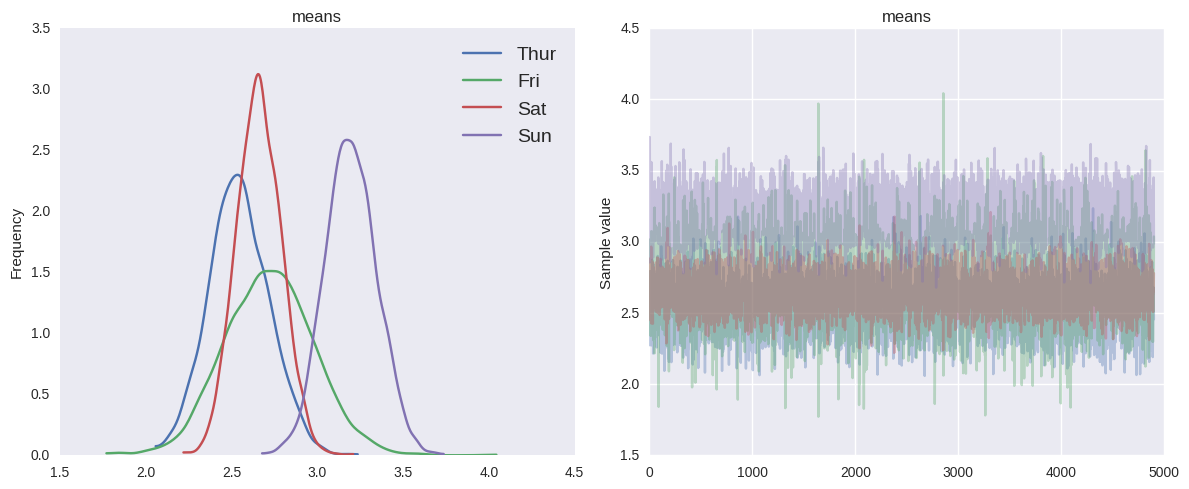

In [134]:
chain_t = trace_t[100:]
axs = pm.traceplot(chain_t, varnames=['means'],figsize=(12,5));
axs0 = axs.ravel()[0]
axs0axs = axs0.axes
lines = axs0axs.get_children()[:4]
for i,line in enumerate(lines):
    line.set_label(catsTransf.categories[i])
axs0.legend(fontsize=14);

In [ ]:
line.get_label

In [71]:
ax.get_label()

''

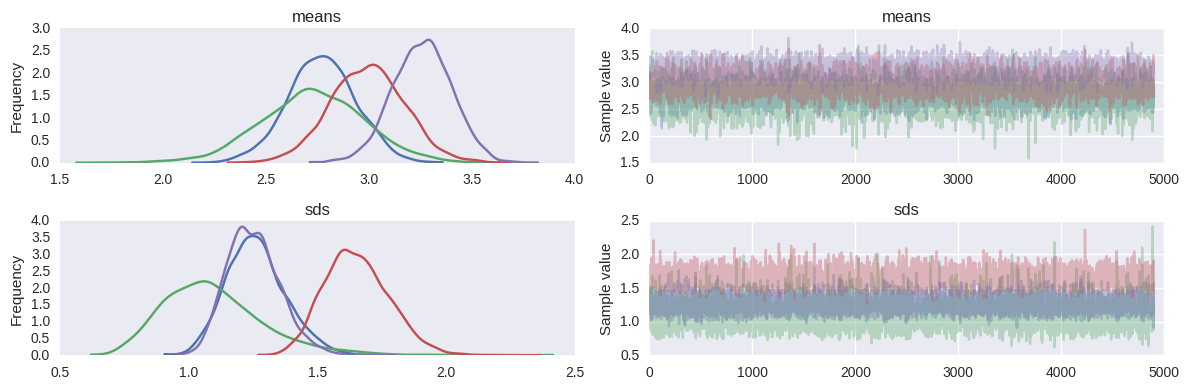

In [64]:
pm.traceplot(chain_cg);

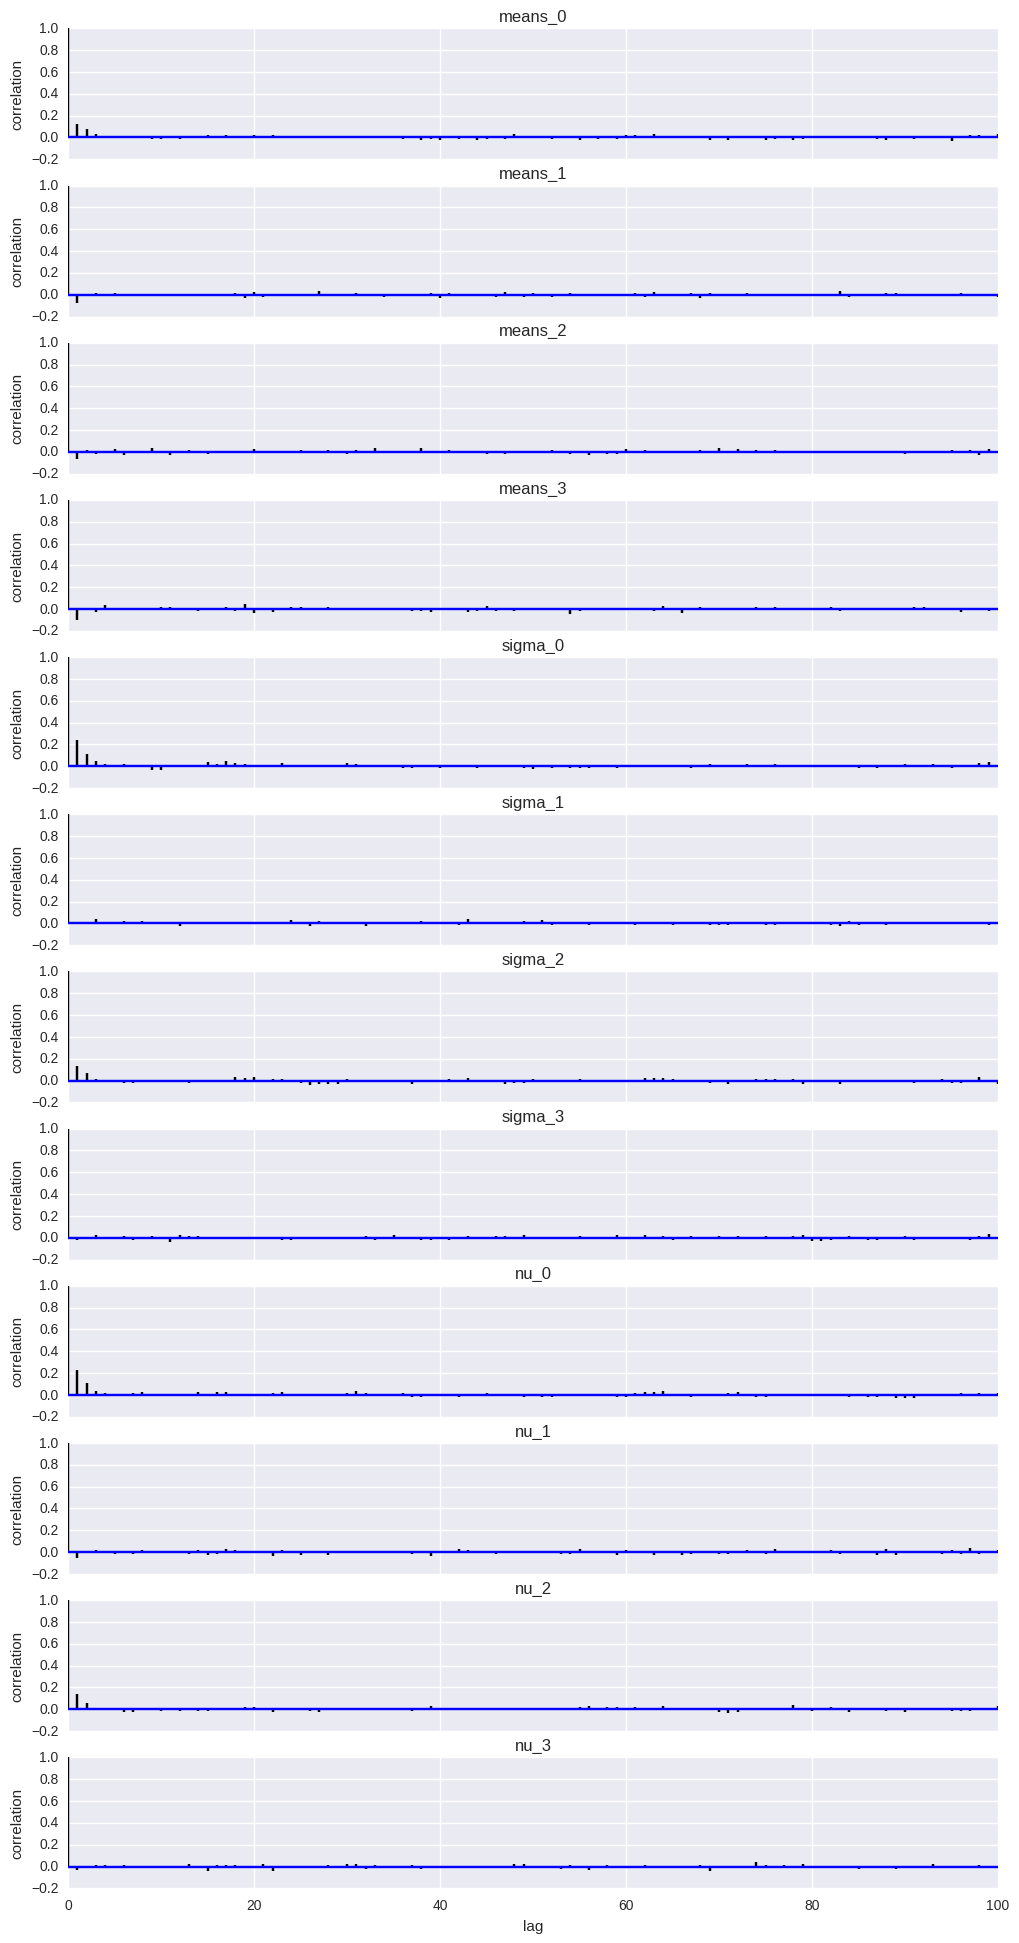

In [60]:
axt = pm.autocorrplot(chain_t)
for ax in axt.ravel():
    ax.set_ylim()

In [61]:
pm.df_summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,2.543941,0.174344,0.003051,2.202183,2.883345
means__1,2.719802,0.258587,0.003434,2.200693,3.206645
means__2,2.657821,0.129349,0.001795,2.424085,2.924275
means__3,3.193395,0.150012,0.002007,2.901872,3.483810
sigma__0,0.995163,0.153500,0.003170,0.699378,1.295320
sigma__1,0.978517,0.216503,0.003532,0.608786,1.430864
sigma__2,0.950046,0.126963,0.002071,0.719469,1.215519
sigma__3,1.135922,0.118285,0.001634,0.913980,1.377010
nu__0,5.262873,2.976906,0.057632,1.232502,11.201743
nu__1,5.947800,3.486183,0.045315,0.772421,12.567971


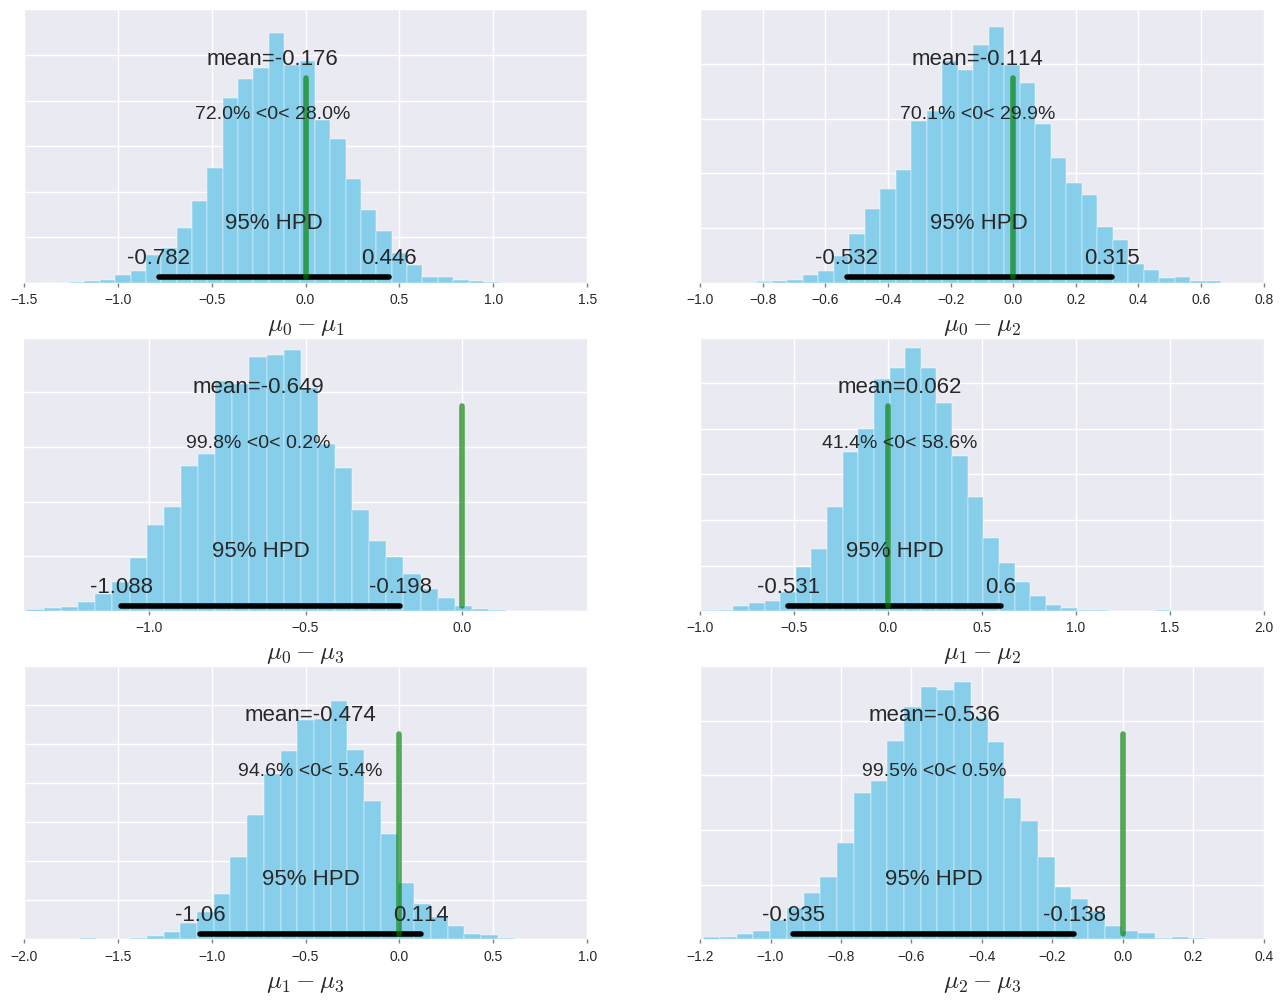

In [62]:
PlotComparisonStats(chain_t)